In [1]:
import os
import sys

lib_path = os.path.abspath("").replace("notebooks", "src")
sys.path.append(lib_path)

import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix
from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
from tqdm.auto import tqdm
import numpy as np
from models import networks
from transformers import BertTokenizer, RobertaTokenizer
root_path = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

/home/kuhaku/mambaforge-pypy3/envs/3m-ser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def eval_svm(opt, checkpoint_path, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = getattr(networks, opt.model_type)(
                num_classes=opt.num_classes,
                num_attention_head=opt.num_attention_head,
                dropout=opt.dropout,
                text_encoder_type=opt.text_encoder_type,
                text_encoder_dim=opt.text_encoder_dim,
                text_unfreeze=opt.text_unfreeze,
                audio_encoder_type=opt.audio_encoder_type,
                audio_encoder_dim=opt.audio_encoder_dim,
                audio_unfreeze=opt.audio_unfreeze,
                audio_norm_type=opt.audio_norm_type,
                fusion_head_output_type=opt.fusion_head_output_type,
            )
    network.to(device)

    # Build dataset
    train_ds, test_ds = build_train_test_dataset(
        opt.data_root,
        opt.batch_size,
        tokenizer,
        opt.audio_max_length,
        text_max_length=opt.text_max_length,
        audio_encoder_type=opt.audio_encoder_type,
    )
    network.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device)).state_dict())
    network.eval()
    network.to(device)

    # Get train features
    train_x = []
    train_y = []
    for every_train_list in tqdm(train_ds):
        input_ids, audio, label = every_train_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            feature = network(input_ids,audio)[1]
            train_x.append(feature.detach().cpu().numpy()[0])
            train_y.append(label.detach().cpu().numpy()[0])
    
    # SVM
    clf = svm.SVC()
    clf.fit(train_x, train_y)
    
    y_actu=[]
    y_pred=[]

    for every_test_list in tqdm(test_ds):
        input_ids, audio, label = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            feature = network(input_ids,audio)[1]
            preds = clf.predict(feature.detach().cpu().numpy())
            y_actu.append(label.detach().cpu().numpy()[0])
            y_pred.append(preds[0])
    print(accuracy_score(y_actu, y_pred))
    wa = balanced_accuracy_score(y_actu, y_pred)
    ua = accuracy_score(y_actu, y_pred)
    print("Weighted Accuracy: ", wa)
    print("Unweighted Accuracy: ", ua)
    cm = confusion_matrix(y_actu, y_pred)
    print(cm)
    cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100

    ax = plt.subplots(figsize=(8, 5.5))[1]
    sns.heatmap(cmn, cmap='YlOrBr', annot=True, square=True, linecolor='black', linewidths=0.75, ax = ax, fmt = '.2f', annot_kws={'size': 16})
    ax.set_xlabel('Predicted', fontsize=18, fontweight='bold')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
    ax.set_ylabel('Ground Truth', fontsize=18, fontweight='bold')
    ax.yaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
    plt.tight_layout()
    plt.savefig(opt.name + '.png', format='png', dpi=1200)
    plt.show()
    
    return wa, ua

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:15<00:00, 59.12it/s]


0.7609860664523044
Weighted Accuracy:  0.7801323228032719
Unweighted Accuracy:  0.7609860664523044
[[157   0   5  15]
 [ 20 192  23  46]
 [  2   6 180  16]
 [ 23  24  43 181]]


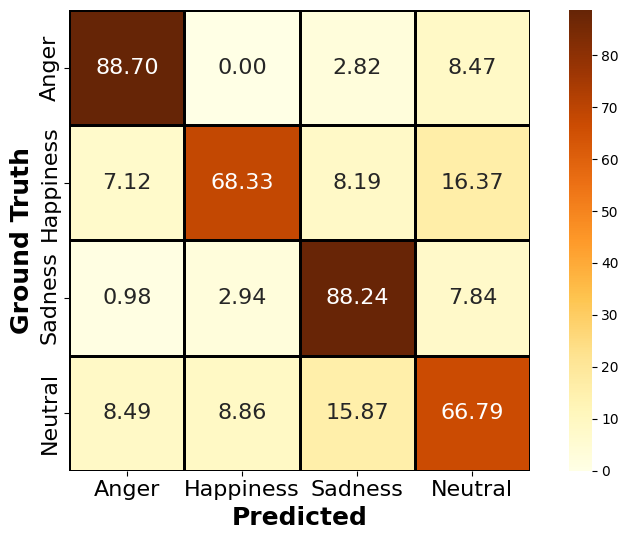

In [3]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.name = "3M-SER_cl_bert_vggish_ICTC"
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_cl_bert_vggish_ICTC/20230729-161256/weights/checkpoint_932000.pt"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
wa, ua = eval_svm(opt, checkpoint_path, tokenizer)
with open("results.txt", "a") as f:
    f.write(f"{opt.name}:\n")
    f.write(f"\tWeighted accuracy: {wa}\n")
    f.write(f"\tUnweighted accuracy: {ua}\n\n")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:15<00:00, 59.31it/s]


0.7652733118971061
Weighted Accuracy:  0.7770042613205588
Unweighted Accuracy:  0.7652733118971061
[[148   2   6  21]
 [ 17 210  16  38]
 [  4   8 174  18]
 [ 17  37  35 182]]


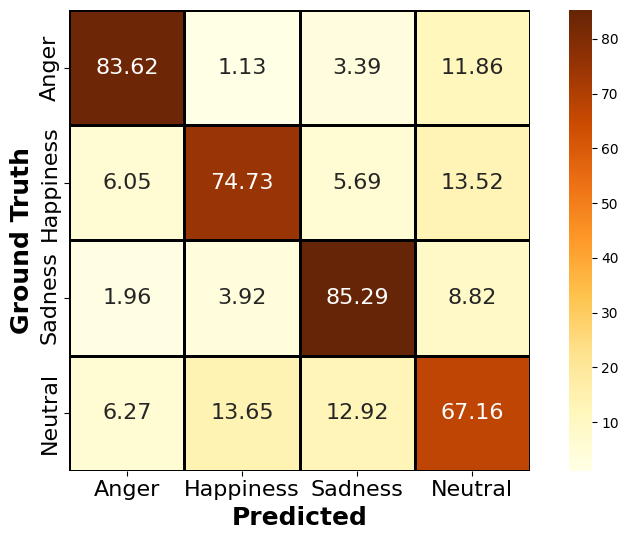

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 56.52it/s]


0.7770632368703109
Weighted Accuracy:  0.7896917523529965
Unweighted Accuracy:  0.7770632368703109
[[147   6   7  17]
 [ 12 210  19  40]
 [  3   4 184  13]
 [ 12  32  43 184]]


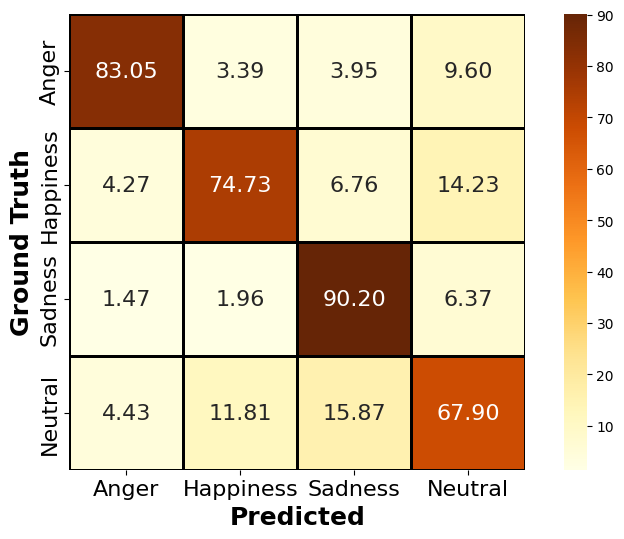

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:14<00:00, 66.62it/s]


0.782422293676313
Weighted Accuracy:  0.7952009265065916
Unweighted Accuracy:  0.782422293676313
[[150   4   5  18]
 [ 13 209  14  45]
 [  3   3 182  16]
 [ 14  32  36 189]]


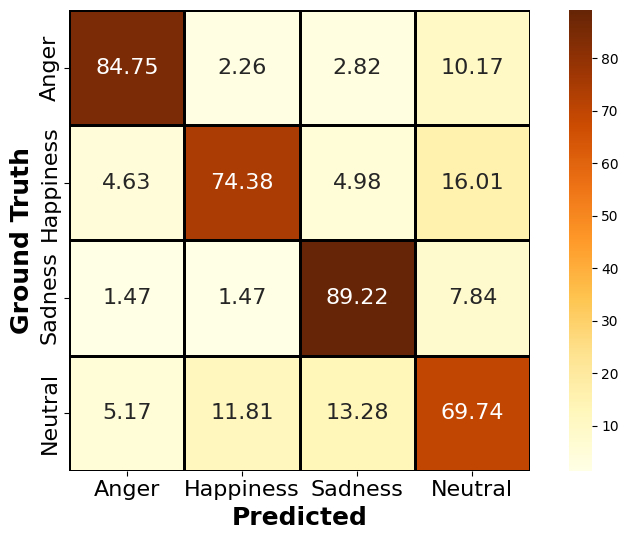

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 56.20it/s]


0.7759914255091104
Weighted Accuracy:  0.791539816997642
Unweighted Accuracy:  0.7759914255091104
[[156   4   5  12]
 [ 15 223  19  24]
 [  3   5 180  16]
 [ 23  40  43 165]]


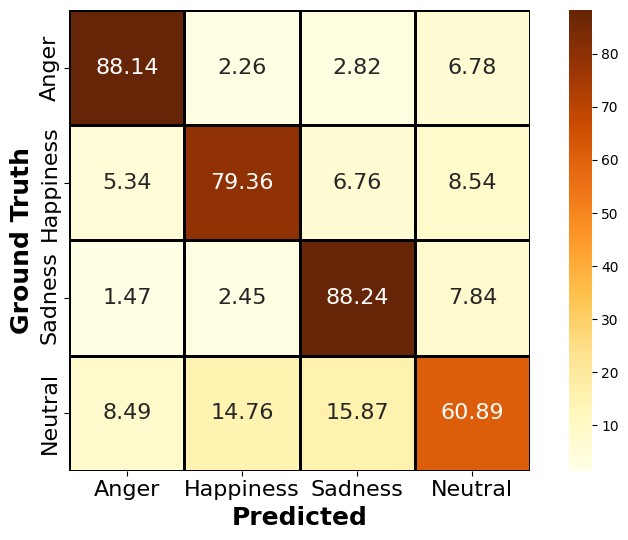

In [4]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i in ["0.5", "1.0", "1.5", "2.0"]:
    opt.name = f"3M-SER_ccl_bert_vggish_ICTC_{i}"
    checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_ccl_bert_vggish_ICTC_optim/lambda_c_{i}|/weights/checkpoint_932000.pt"
    wa, ua = eval_svm(opt, checkpoint_path, tokenizer)
    with open("results.txt", "a") as f:
        f.write(f"{opt.name}:\n")
        f.write(f"\tWeighted accuracy: {wa}\n")
        f.write(f"\tUnweighted accuracy: {ua}\n\n")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 56.99it/s]


0.5809217577706324
Weighted Accuracy:  0.5734622574695143
Unweighted Accuracy:  0.5809217577706324
[[ 79  44   4  50]
 [ 21 141  13 106]
 [  4  10 130  60]
 [  9  44  26 192]]


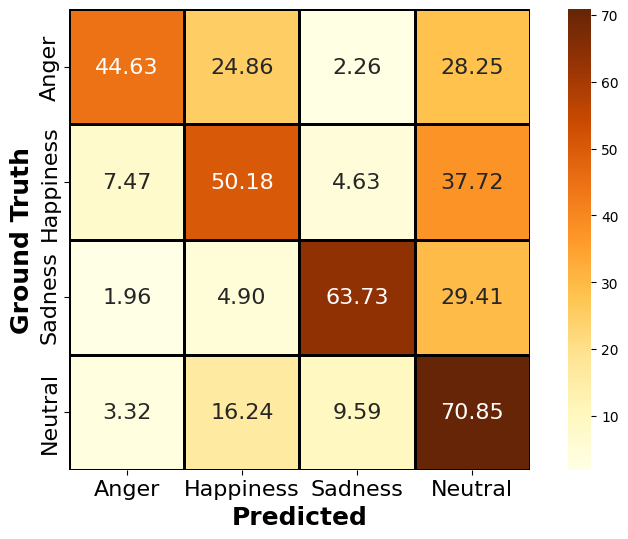

In [5]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.name = "SERVER_cl_bert_vggish_ICTC"
opt.model_type = "SERVER"
opt.feat_dim = 256
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
checkpoint_path = f"{root_path}/scripts/checkpoints/SERVER_cl_bert_vggish_ICTC/20230729-161104/weights/checkpoint_932000.pt"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
wa, ua = eval_svm(opt, checkpoint_path, tokenizer)
with open("results.txt", "a") as f:
    f.write(f"{opt.name}:\n")
    f.write(f"\tWeighted accuracy: {wa}\n")
    f.write(f"\tUnweighted accuracy: {ua}\n\n")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 55.75it/s]


0.594855305466238
Weighted Accuracy:  0.5865284067300142
Unweighted Accuracy:  0.594855305466238
[[ 84  38   4  51]
 [ 16 146  13 106]
 [  4   9 126  65]
 [  8  41  23 199]]


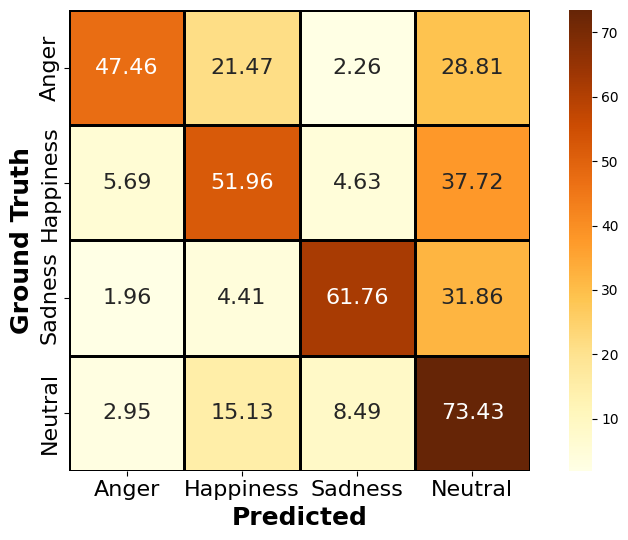

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 56.53it/s]


0.5969989281886388
Weighted Accuracy:  0.5894693072756099
Unweighted Accuracy:  0.5969989281886388
[[ 85  36   4  52]
 [ 14 146  13 108]
 [  4   9 128  63]
 [  7  41  25 198]]


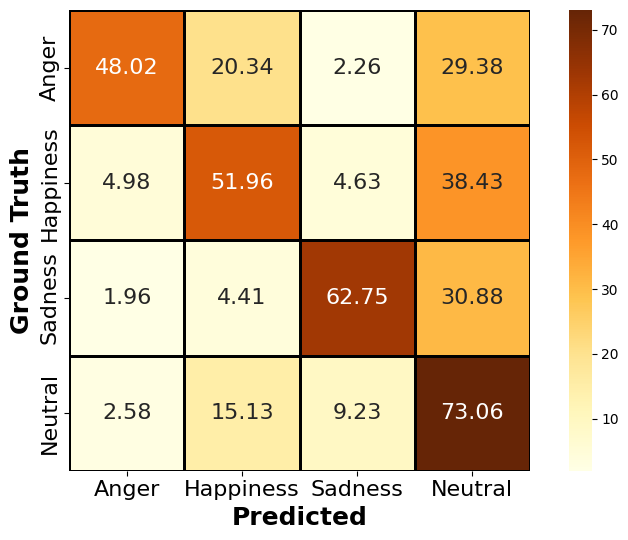

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:17<00:00, 54.76it/s]


0.6087888531618435
Weighted Accuracy:  0.6025359150472924
Unweighted Accuracy:  0.6087888531618435
[[ 88  36   5  48]
 [ 18 148  11 104]
 [  4  10 133  57]
 [  9  36  27 199]]


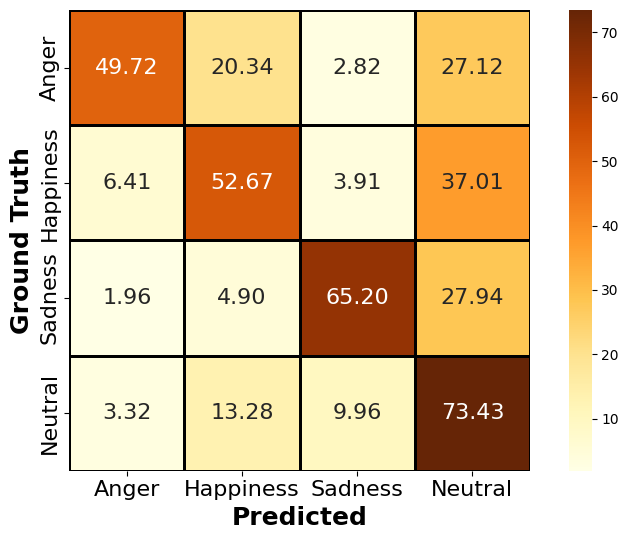

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:17<00:00, 54.61it/s]


0.5991425509110396
Weighted Accuracy:  0.5929657869942239
Unweighted Accuracy:  0.5991425509110396
[[ 87  36   4  50]
 [ 17 144  13 107]
 [  4  10 130  60]
 [  7  39  27 198]]


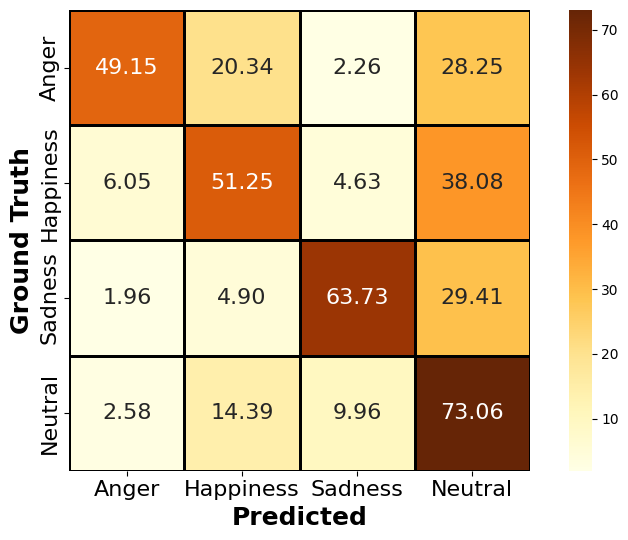

In [6]:
from configs.bert_vggish_ICTC import Config

opt = Config()
opt.model_type = "SERVER"
opt.feat_dim = 256
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i in ["0.5", "1.0", "1.5", "2.0"]:
    opt.name = f"SERVER_ccl_bert_vggish_ICTC_{i}"
    checkpoint_path = f"{root_path}/scripts/checkpoints/SERVER_ccl_bert_vggish_ICTC_optim/lambda_c_{i}|/weights/checkpoint_932000.pt"
    wa, ua = eval_svm(opt, checkpoint_path, tokenizer)
    with open("results.txt", "a") as f:
        f.write(f"{opt.name}:\n")
        f.write(f"\tWeighted accuracy: {wa}\n")
        f.write(f"\tUnweighted accuracy: {ua}\n\n")

In [7]:
def eval(opt, checkpoint_path, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = getattr(networks, opt.model_type)(
                num_classes=opt.num_classes,
                num_attention_head=opt.num_attention_head,
                dropout=opt.dropout,
                text_encoder_type=opt.text_encoder_type,
                text_encoder_dim=opt.text_encoder_dim,
                text_unfreeze=opt.text_unfreeze,
                audio_encoder_type=opt.audio_encoder_type,
                audio_encoder_dim=opt.audio_encoder_dim,
                audio_unfreeze=opt.audio_unfreeze,
                audio_norm_type=opt.audio_norm_type,
                fusion_head_output_type=opt.fusion_head_output_type,
            )
    network.to(device)

    # Build dataset
    _, test_ds = build_train_test_dataset(
        opt.data_root,
        opt.batch_size,
        tokenizer,
        opt.audio_max_length,
        text_max_length=opt.text_max_length,
        audio_encoder_type=opt.audio_encoder_type,
    )
    network.load_state_dict(torch.load(checkpoint_path, map_location=torch.device(device)).state_dict())
    network.eval()
    network.to(device)

    y_actu=[]
    y_pred=[]

    for every_test_list in tqdm(test_ds):
        input_ids, audio, label = every_test_list
        input_ids = input_ids.to(device)
        audio = audio.to(device)
        label = label.to(device)
        with torch.no_grad():
            output = network(input_ids,audio)[0]
            _, preds = torch.max(output, 1)
            y_actu.append(label.detach().cpu().numpy()[0])
            y_pred.append(preds.detach().cpu().numpy()[0])
    print(accuracy_score(y_actu, y_pred))
    wa = balanced_accuracy_score(y_actu, y_pred)
    ua = accuracy_score(y_actu, y_pred)
    print("Weighted Accuracy: ", wa)
    print("Unweighted Accuracy: ", ua)
    cm = confusion_matrix(y_actu, y_pred)
    print(cm)
    cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100

    ax = plt.subplots(figsize=(8, 5.5))[1]
    sns.heatmap(cmn, cmap='YlOrBr', annot=True, square=True, linecolor='black', linewidths=0.75, ax = ax, fmt = '.2f', annot_kws={'size': 16})
    ax.set_xlabel('Predicted', fontsize=18, fontweight='bold')
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
    ax.set_ylabel('Ground Truth', fontsize=18, fontweight='bold')
    ax.yaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
    plt.tight_layout()
    plt.savefig(opt.name + '.png', format='png', dpi=1200)
    plt.show()
    
    return wa, ua

In [8]:
from configs.bert_vggish_ICTC import Config

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 55.40it/s]


0.6580921757770632
Weighted Accuracy:  0.6657907701084653
Unweighted Accuracy:  0.6580921757770632
[[112  36   9  20]
 [ 17 195  37  32]
 [  6  12 168  18]
 [ 22  55  55 139]]


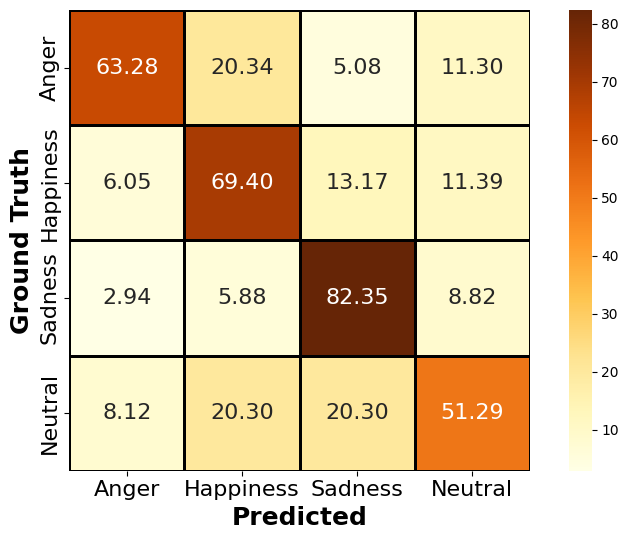

In [9]:
opt = Config()
opt.model_type = "SERVER"
opt.feat_dim = 256
opt.name = "SERVER_cel_cl_bert_vggish_ICTC"
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

checkpoint_path = f"{root_path}/scripts/checkpoints/SERVER_cel_cl_bert_vggish_ICTC/20230801-094024/weights/best_acc/checkpoint_0.pt"
wa, ua = eval(opt, checkpoint_path, tokenizer)
with open("results.txt", "a") as f:
    f.write(f"{opt.name}:\n")
    f.write(f"\tWeighted accuracy: {wa}\n")
    f.write(f"\tUnweighted accuracy: {ua}\n\n")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:17<00:00, 54.84it/s]


0.6570203644158628
Weighted Accuracy:  0.6566955355344934
Unweighted Accuracy:  0.6570203644158628
[[113  18  10  36]
 [ 21 182  22  56]
 [  5  16 138  45]
 [ 13  41  37 180]]


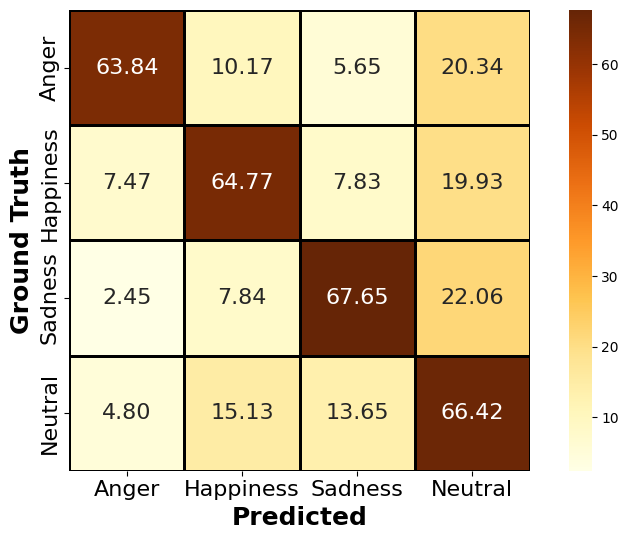

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 57.51it/s]


0.6559485530546624
Weighted Accuracy:  0.6636680848142061
Unweighted Accuracy:  0.6559485530546624
[[112  28  13  24]
 [ 20 185  38  38]
 [  6  13 166  19]
 [ 21  51  50 149]]


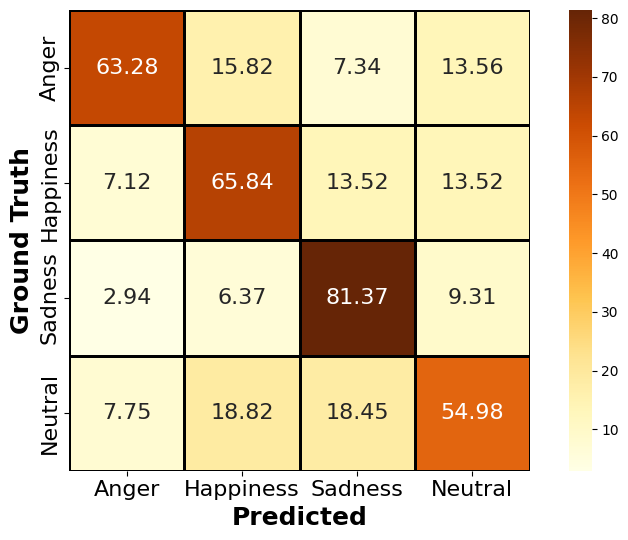

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:12<00:00, 76.12it/s]


0.6516613076098606
Weighted Accuracy:  0.6649435928250669
Unweighted Accuracy:  0.6516613076098606
[[128  15   9  25]
 [ 42 171  24  44]
 [  8  14 155  27]
 [ 24  52  41 154]]


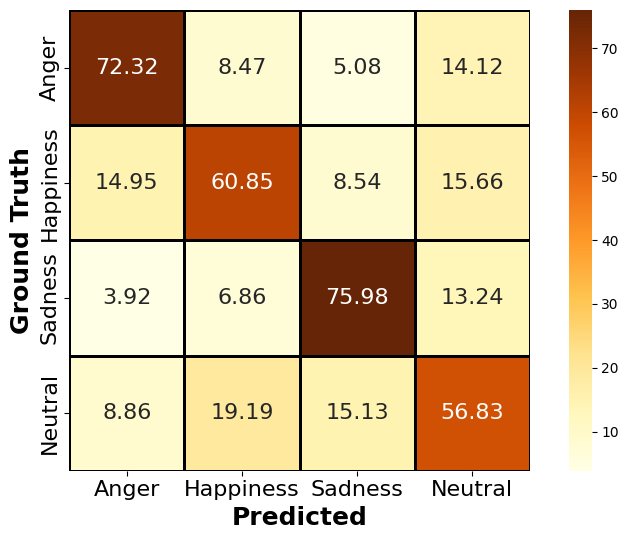

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 55.28it/s]


0.647374062165059
Weighted Accuracy:  0.648230397610991
Unweighted Accuracy:  0.647374062165059
[[105  41   9  22]
 [ 19 206  24  32]
 [  5  24 153  22]
 [ 21  74  36 140]]


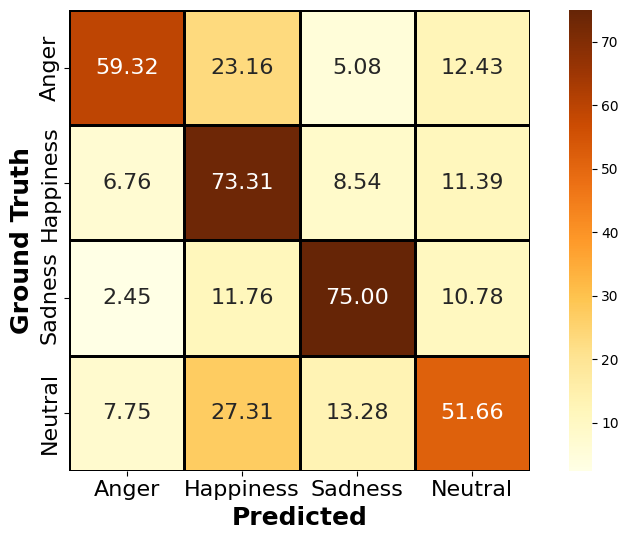

In [10]:
opt = Config()
opt.model_type = "SERVER"
opt.feat_dim = 256
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i in ["0.5", "1.0", "1.5", "2.0"]:
    opt.name = f"SERVER_cel_ccl_bert_vggish_ICTC_{i}"
    checkpoint_path = f"{root_path}/scripts/checkpoints/SERVER_bert_vggish_ICTC_optim/lambda_c_{i}|/weights/best_acc/checkpoint_0.pt"
    wa, ua = eval(opt, checkpoint_path, tokenizer)
    with open("results.txt", "a") as f:
        f.write(f"{opt.name}:\n")
        f.write(f"\tWeighted accuracy: {wa}\n")
        f.write(f"\tUnweighted accuracy: {ua}\n\n")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 56.59it/s]


0.7856377277599143
Weighted Accuracy:  0.7934558847696034
Unweighted Accuracy:  0.7856377277599143
[[144   3   6  24]
 [ 13 220  11  37]
 [  3   7 178  16]
 [ 14  36  30 191]]


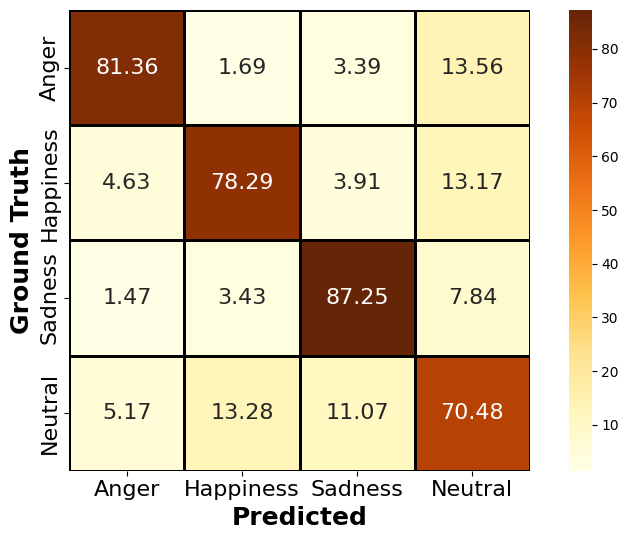

In [11]:
opt = Config()
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.name = "3M-SER_cel_cl_bert_vggish_ICTC"
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_cel_cl_bert_vggish_ICTC/20230801-093922/weights/best_acc/checkpoint_0.pt"
wa, ua = eval(opt, checkpoint_path, tokenizer)
with open("results.txt", "a") as f:
    f.write(f"{opt.name}:\n")
    f.write(f"\tWeighted accuracy: {wa}\n")
    f.write(f"\tUnweighted accuracy: {ua}\n\n")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 54.98it/s]


0.8027867095391211
Weighted Accuracy:  0.8143928168089918
Unweighted Accuracy:  0.8027867095391211
[[154   7   5  11]
 [ 14 218  17  32]
 [  2   2 182  18]
 [ 18  29  29 195]]


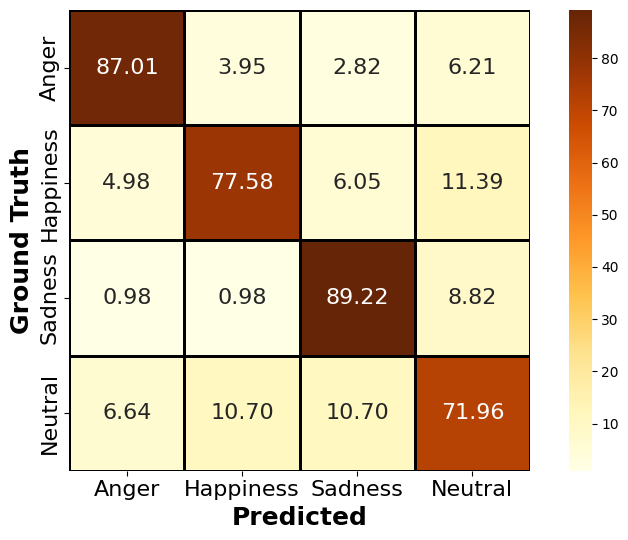

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 54.98it/s]


0.7984994640943194
Weighted Accuracy:  0.8107508856690381
Unweighted Accuracy:  0.7984994640943194
[[155   6   4  12]
 [ 16 213  12  40]
 [  5   2 180  17]
 [ 19  31  24 197]]


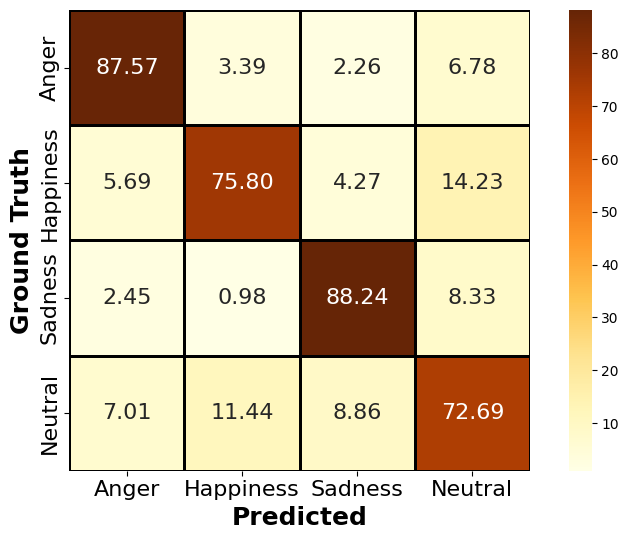

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 56.15it/s]


0.7952840300107181
Weighted Accuracy:  0.8039962541256569
Unweighted Accuracy:  0.7952840300107181
[[153   5   3  16]
 [ 11 240  12  18]
 [  2   8 173  21]
 [ 13  43  39 176]]


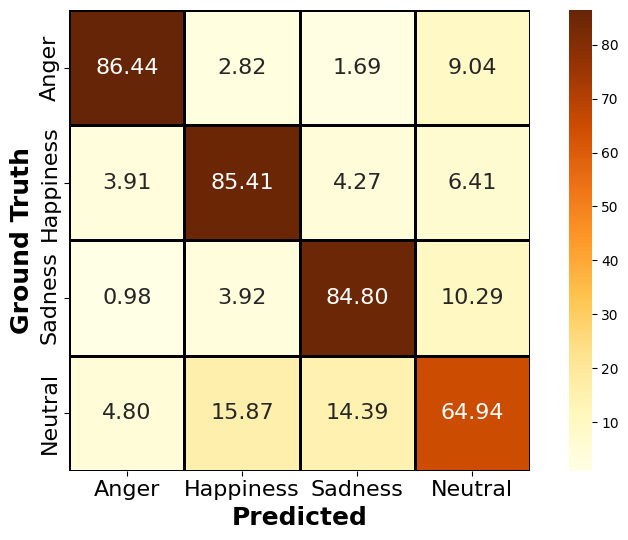

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 933/933 [00:16<00:00, 56.19it/s]


0.8006430868167203
Weighted Accuracy:  0.8137526457322669
Unweighted Accuracy:  0.8006430868167203
[[159   2   3  13]
 [ 18 219  12  32]
 [  5   5 178  16]
 [ 19  35  26 191]]


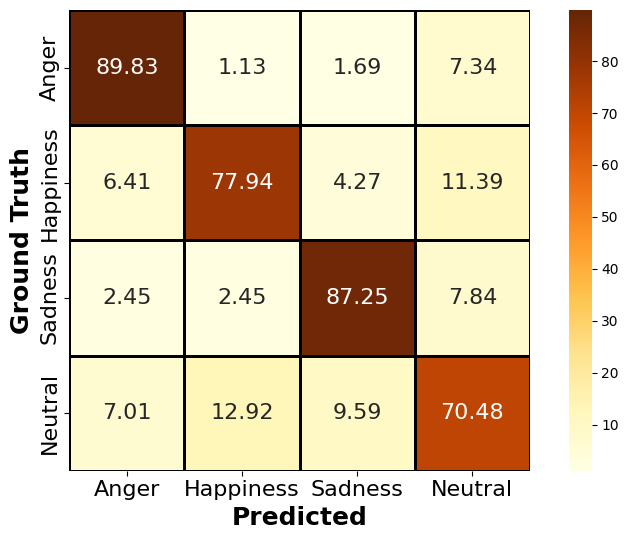

In [12]:
opt = Config()
opt.model_type = "MMSERA"
opt.feat_dim = 128
opt.data_root = f"{root_path}/scripts/data/IEMOCAP"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

for i in ["0.5", "1.0", "1.5", "2.0"]:
    opt.name = f"MMSERA_cel_ccl_bert_vggish_ICTC_{i}"
    checkpoint_path = f"{root_path}/scripts/checkpoints/3M-SER_bert_vggish_ICTC_optim/lambda_c_{i}|/weights/best_acc/checkpoint_0.pt"
    wa, ua = eval(opt, checkpoint_path, tokenizer)
    with open("results.txt", "a") as f:
        f.write(f"{opt.name}:\n")
        f.write(f"\tWeighted accuracy: {wa}\n")
        f.write(f"\tUnweighted accuracy: {ua}\n\n")